In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

 Evaluate bi-encoder

Calculate ROC-AUC for various bi-encoder models to see which one performs best

Results
- lr = 0.00005 hard_negs = 15 easy_negs = 15 vocab_size = 256 AUC = 0.9785468571658106
- lr = 0.00005 hard_negs = 10 easy_negs = 20 vocab_size = 2048 AUC = 0.9801656491546622
- lr = 0.00005 hard_negs = 10 easy_negs = 30 vocab_size = 2048 AUC = 
- lr = 0.0001 hard_negs = 15 easy_negs = 15 vocab_size = 2048 AUC = 0.9791479317312332
- lr = 0.00005 hard_negs = 15 easy_negs = 15 vocab_size = 2048 AUC = 0.9796675370074298
- old clf AUC = 0.9835559336624864
- lr = 0.00005 ce vocab_size = 2048 AUC = 0.9855205231724369
- 

In [2]:
from collections import defaultdict

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm

from nama.data.filesystem import download_file_from_s3
from nama.models.tokenizer import get_tokenize_function_and_vocab

In [12]:
# config

# TODO run both given and surname
given_surname = "given"
# given_surname = "surname"

num_epochs = 8
embedding_dim = 256
hard_negs = 10
easy_negs = 30
bi_encoder_vocab_size = 2048
learning_rate = 0.00005
max_tokens = 10
very_high_freq_threshold = 100000

std_path = f"../references/std_{given_surname}.txt"
frequencies_path = f"s3://fs-nama-data/2024/familysearch-names/interim/tree-hr-{given_surname}-aggr-v2.parquet"
tokenizer_path=f"s3://fs-nama-data/2024/nama-data/data/models/fs-{given_surname}-subword-tokenizer-{bi_encoder_vocab_size}.json"
# bi_encoder_path = f"s3://fs-nama-data/2024/nama-data/data/models/bi_encoder-{given_surname}-{num_epochs}-{embedding_dim}-{hard_negs}-{easy_negs}-{bi_encoder_vocab_size}-{learning_rate}.pth"
bi_encoder_path = f"s3://fs-nama-data/2024/nama-data/data/models/bi_encoder-ce-{given_surname}-{num_epochs}-{embedding_dim}-{num_epochs}-{bi_encoder_vocab_size}-{learning_rate}.pth"

# old bi-encoder and tokenizer
# bi_encoder_path = "/home/data/nama/nama-data/models/bi_encoder-given-cecommon+0+aug-0-1.pth"
# tokenizer_path= "/home/data/nama/nama-data/models/fs-given-subword-tokenizer-2000f.json"

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print("cuda total", torch.cuda.get_device_properties(0).total_memory)
    print("cuda reserved", torch.cuda.memory_reserved(0))
    print("cuda allocated", torch.cuda.memory_allocated(0))

cuda:0
True
cuda total 8141471744
cuda reserved 0
cuda allocated 0


In [5]:
# load buckets
bucket_names = defaultdict(set)
with open(std_path, 'rt') as f:
    for line in f.readlines():
        names = line.strip().replace(':', ' ').split(' ')
        bucket_name = names[0]
        for name in names:
            name = name.strip()
            if len(name) == 0:
                continue
            bucket_names[bucket_name].add(name)
print(len(bucket_names))

8878


In [6]:
# load counts
path = download_file_from_s3(frequencies_path) if frequencies_path.startswith("s3://") else frequencies_path
counts_df = pd.read_parquet(path)
counts_df = counts_df[['alt_name', 'total_alt_name_frequency']].drop_duplicates()
print(counts_df.shape)
name_frequency = dict(zip(counts_df['alt_name'], counts_df['total_alt_name_frequency']))
print(len(name_frequency))

(6148634, 2)
6148634


In [7]:
very_high_freq_names = [name for name, freq in name_frequency.items() if freq > very_high_freq_threshold]
print(len(very_high_freq_names))

2104


In [8]:
# load tokenizer
path = download_file_from_s3(tokenizer_path) if tokenizer_path.startswith("s3://") else tokenizer_path
tokenize, tokenizer_vocab = get_tokenize_function_and_vocab(tokenizer_path=path, max_tokens=max_tokens)
print(len(tokenizer_vocab))
print(tokenize('dallan'))

2048
[1584, 489, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
# load bi-encoder
path = download_file_from_s3(bi_encoder_path) if bi_encoder_path.startswith("s3://") else bi_encoder_path
model = torch.load(path)
model.eval()

/tmp/ipykernel_3791000/3279248562.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


BiEncoder(
  (embedding): Embedding(2048, 256)
  (positional_embedding): Embedding(10, 256)
  (pooling): AdaptiveAvgPool1d(output_size=1)
)

## Compute ROC-AUC for all buckets

- Names in the bucket are positives
- very high freq names are negatives

In [14]:
def plot_roc_auc(y_true, scores):
    """
    Calculate and plot ROC curve, return AUC score
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    scores : array-like
        Target scores (can be positive/negative numbers, probabilities, etc.)
        Higher values should indicate higher likelihood of positive class
        
    Returns:
    --------
    float
        Area Under the ROC Curve (AUC) score
    """
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    
    # Create ROC curve plot
    plt.figure(figsize=(8, 6))
    
    # Set up grid with 0.05 intervals
    plt.gca().set_xticks(np.arange(0, 1.05, 0.05))
    plt.gca().set_yticks(np.arange(0, 1.05, 0.05))
    plt.grid(True, alpha=1.0, which='both')
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'bi-encoder ROC curve (AUC = {roc_auc:.2f})')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=1.0)
    
    # Show plot
    plt.show()
    
    return roc_auc

In [15]:
y_true = []
scores = []
total_pos = 0
total_neg = 0
sample_rate = 1
for bucket_name, names in tqdm(list(bucket_names.items())[::sample_rate]):
    bucket_name_tokens = tokenize(bucket_name)
    for name in names:
        name_tokens = tokenize(name)
        sim = model.predict(bucket_name_tokens, name_tokens)
        y_true.append(1)
        scores.append(sim)
        total_pos += 1
    for name in very_high_freq_names:
        name_tokens = tokenize(name)
        sim = model.predict(bucket_name_tokens, name_tokens)
        y_true.append(0)
        scores.append(sim)
        total_neg += 1

100%|██████████| 8878/8878 [1:43:33<00:00,  1.43it/s]


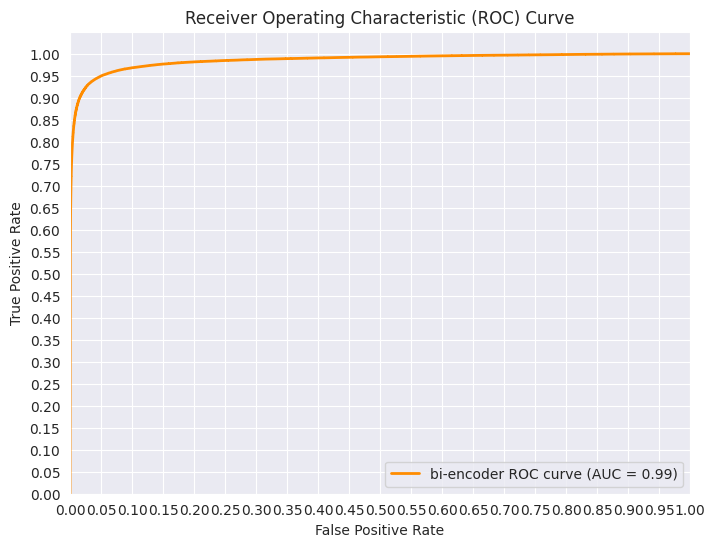

In [16]:
score = plot_roc_auc(y_true, scores)

In [17]:
print(total_pos, total_neg, score)

96010 18679312 0.9855205231724369


In [18]:
print(hard_negs)
print(easy_negs)
print(bi_encoder_vocab_size)
print(learning_rate)

10
30
2048
5e-05
